In [1]:
import pandas as pd
from sqlalchemy import create_engine
    
engine = create_engine("sqlite:///mta_data.db")
df21 = pd.read_sql("SELECT * FROM mta_data_H1_19to21;", engine)

df = df21.copy()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df.info()
df.columns
df.head(5)
df.value_counts()
df.groupby("STATION")["DT"].count()
df.TIME.value_counts().head(30)
df.TIME.value_counts().tail(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18822126 entries, 0 to 18822125
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   CA        object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DT        object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 1.5+ GB


14:51:51    1
17:03:20    1
21:51:26    1
02:03:26    1
06:15:26    1
10:27:26    1
20:49:59    1
01:01:59    1
19:43:43    1
15:51:20    1
06:31:43    1
02:19:43    1
22:07:43    1
20:26:27    1
00:38:27    1
04:50:27    1
00:00:05    1
15:36:05    1
11:24:05    1
23:39:43    1
19:27:43    1
15:15:43    1
11:03:43    1
06:51:43    1
02:39:43    1
13:43:43    1
10:37:59    1
03:03:13    1
04:07:43    1
21:59:43    1
Name: TIME, dtype: int64

In [3]:
import datetime as dt
df["DATE_TIME"] = pd.to_datetime(df.DT + " " + df.TIME, format = "%m/%d/%Y %H:%M:%S") #CONVERT TO DATETIME

In [4]:
(df
.groupby(["CA","UNIT","SCP","STATION","DATE_TIME"])
.ENTRIES.count()
.reset_index()
.sort_values("ENTRIES",ascending=False)).head(7) 

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
9245464,N519,R461,00-03-01,B'WAY-LAFAYETTE,2019-03-24 13:00:00,2
1602360,B024,R211,00-05-00,KINGS HWY,2021-05-05 00:00:00,2
1602353,B024,R211,00-05-00,KINGS HWY,2021-05-03 20:00:00,2
1602354,B024,R211,00-05-00,KINGS HWY,2021-05-04 00:00:00,2
4515226,N045,R187,01-06-00,81 ST-MUSEUM,2019-07-09 09:00:00,2
1602356,B024,R211,00-05-00,KINGS HWY,2021-05-04 08:00:00,2
1602357,B024,R211,00-05-00,KINGS HWY,2021-05-04 12:00:00,2


In [5]:
df.sort_values(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=True)
df.sort_values(["DATE_TIME", "DESC"], inplace=True, ascending=[True,False])

df.drop_duplicates(subset=["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [6]:
df.drop(["EXITS"], axis=1, inplace=True, errors="ignore")

In [7]:
df.shape

(18821831, 11)

In [8]:
df_4hr = df.copy()
df_4hr[["PREV_DATE","PREV_TIME","PREV_DATETIME","PREV_ENTRIES"]] = (df_4hr.groupby(["CA", "UNIT", "SCP", "STATION"])[["DT","TIME","DATE_TIME","ENTRIES"]].shift(1))
df_4hr.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [9]:
(df_4hr["ENTRIES"] - df_4hr["PREV_ENTRIES"]).describe()

count    1.881666e+07
mean     3.982548e+02
std      3.538143e+06
min     -2.129095e+09
25%      2.000000e+00
50%      2.600000e+01
75%      1.050000e+02
max      2.139010e+09
dtype: float64

In [10]:
df_4hr[df_4hr["ENTRIES"] < df_4hr["PREV_ENTRIES"]].shape

(161486, 15)

In [11]:
(df_4hr[df_4hr["ENTRIES"] < df_4hr["PREV_ENTRIES"]]
 .groupby(["CA","UNIT","SCP","STATION"])
 .size())

CA     UNIT  SCP       STATION        
A002   R051  02-03-02  59 ST                 1
             02-05-00  59 ST                 1
             02-06-00  59 ST                 2
A006   R079  00-00-04  5 AV/59 ST            1
             00-03-00  5 AV/59 ST            1
                                          ... 
R730   R431  00-00-04  EASTCHSTER/DYRE    3482
S101   R070  00-00-04  ST. GEORGE            1
             00-00-06  ST. GEORGE            1
TRAM1  R468  00-00-01  RIT-MANHATTAN         2
TRAM2  R469  00-05-00  RIT-ROOSEVELT         1
Length: 1664, dtype: int64

In [12]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter
    
    if counter > max_counter:
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    
    if counter > max_counter:
        return 0
    
    return counter

df_4hr["DAILY_ENTRIES"] = df_4hr.apply(get_daily_counts, axis=1, max_counter=23040)

entries: 393251 <-- 84493189.0
entries: 0 <-- 83886080.0
entries: 1096001 <-- 268496023.0
entries: 8272 <-- 56777.0
entries: 364 <-- 24866.0
entries: 676 <-- 28873.0
entries: 3245 <-- 120048902.0
entries: 0 <-- 67289.0
entries: 12 <-- 1029102.0
entries: 1924779 <-- 147547.0
entries: 17 <-- 2157223.0
entries: 10 <-- 142311.0
entries: 52 <-- 211961.0
entries: 147548 <-- 1924795.0
entries: 0 <-- 458752.0
entries: 38 <-- 2414813.0
entries: 0 <-- 294809.0
entries: 11 <-- 270306326.0
entries: 16 <-- 1847577.0
entries: 16 <-- 3173773.0
entries: 16 <-- 12846702.0
entries: 0 <-- 271105.0
entries: 0 <-- 43516.0
entries: 326 <-- 79674.0
entries: 133 <-- 1401877.0
entries: 5 <-- 873860.0
entries: 186 <-- 81102.0
entries: 587240300 <-- 2310648.0
entries: 12461 <-- 1752692.0
entries: 0 <-- 159883.0
entries: 62 <-- 552625973.0
entries: 335 <-- 53638.0
entries: 3 <-- 73342.0
entries: 151 <-- 193698.0
entries: 18 <-- 25018.0
entries: 91 <-- 35848.0
entries: 0 <-- 32327.0
entries: 649 <-- 9638103.0
entr

entries: 4400722 <-- 26594498.0
entries: 12428476 <-- 26637117.0
entries: 13575041 <-- 14497941.0
entries: 10757180 <-- 67604768.0
entries: 14656605 <-- 5196016.0
entries: 473562 <-- 6749425.0
entries: 2302715 <-- 15198190.0
entries: 1911046 <-- 4050583.0
entries: 495298 <-- 893162.0
entries: 2900248 <-- 1350363.0
entries: 4126050 <-- 292530.0
entries: 1675023 <-- 1447456.0
entries: 2297285 <-- 290287.0
entries: 1284 <-- 3372192.0
entries: 67 <-- 100375.0
entries: 458759 <-- 138930.0
entries: 646 <-- 6738017.0
entries: 50331654 <-- 458763.0
entries: 0 <-- 89680.0
entries: 0 <-- 170345.0
entries: 110 <-- 47022.0
entries: 1661796380 <-- 50331733.0
entries: 402692234 <-- 1605956.0
entries: 35 <-- 67106.0
entries: 2402558 <-- 2378199.0
entries: 819 <-- 1522416.0
entries: 589928 <-- 402692234.0
entries: 94 <-- 167184.0
entries: 235207703 <-- 68073706.0
entries: 0 <-- 71826.0
entries: 1122 <-- 8296931.0
entries: 43 <-- 1830476.0
entries: 6 <-- 11241357.0
entries: 2 <-- 335514.0
entries: 0 <-

entries: 113028 <-- 18431.0
entries: 18437 <-- 113028.0
entries: 113035 <-- 18437.0
entries: 18441 <-- 113035.0
entries: 113038 <-- 18441.0
entries: 18443 <-- 113038.0
entries: 113038 <-- 18443.0
entries: 18450 <-- 113038.0
entries: 24 <-- 127446.0
entries: 113038 <-- 18450.0
entries: 18452 <-- 113038.0
entries: 0 <-- 5176463.0
entries: 113056 <-- 18452.0
entries: 18454 <-- 113056.0
entries: 113076 <-- 18454.0
entries: 18457 <-- 113076.0
entries: 113102 <-- 18457.0
entries: 460397 <-- 299439.0
entries: 18461 <-- 113102.0
entries: 113125 <-- 18461.0
entries: 11 <-- 100831.0
entries: 18461 <-- 113126.0
entries: 113127 <-- 18461.0
entries: 18463 <-- 113127.0
entries: 113146 <-- 18463.0
entries: 34 <-- 31061.0
entries: 18463 <-- 113146.0
entries: 113173 <-- 18463.0
entries: 18482 <-- 113173.0
entries: 113303 <-- 18482.0
entries: 18483 <-- 113303.0
entries: 113331 <-- 18483.0
entries: 18487 <-- 113331.0
entries: 8 <-- 2021820.0
entries: 113350 <-- 18487.0
entries: 18488 <-- 113350.0
entries

entries: 1 <-- 884650.0
entries: 62 <-- 337720.0
entries: 55 <-- 433785.0
entries: 27 <-- 308789.0
entries: 1 <-- 615448.0
entries: 8 <-- 185904.0
entries: 20 <-- 189870.0
entries: 75 <-- 84346.0
entries: 187 <-- 113427.0
entries: 103 <-- 60788.0
entries: 615476 <-- 1.0
entries: 5 <-- 121074.0
entries: 51 <-- 231837.0
entries: 20 <-- 251794.0
entries: 1 <-- 37594.0
entries: 1376270 <-- 8706.0
entries: 77 <-- 228532.0
entries: 50 <-- 95792.0
entries: 284 <-- 1652257.0
entries: 228 <-- 54453.0
entries: 867 <-- 78178.0
entries: 0 <-- 1078800.0
entries: 6 <-- 1488298.0
entries: 0 <-- 393216.0
entries: 0 <-- 34859.0
entries: 606 <-- 1692557.0
entries: 1 <-- 23976.0
entries: 8 <-- 796924.0
entries: 13 <-- 101835.0
entries: 2 <-- 23944.0
entries: 38 <-- 61933.0
entries: 130 <-- 355689.0
entries: 22 <-- 4086581.0
entries: 1692665 <-- 606.0
entries: 52 <-- 37578.0
entries: 30 <-- 108599.0
entries: 92 <-- 35470.0
entries: 86 <-- 31186.0
entries: 4 <-- 242269.0
entries: 91 <-- 937424.0
entries: 1

entries: 620044 <-- 569503.0
entries: 6841260 <-- 6644068.0
entries: 1986694 <-- 1741607.0
entries: 18456907 <-- 18087170.0
entries: 1856683 <-- 1794426.0
entries: 115089 <-- 322589.0
entries: 8932297 <-- 8729331.0
entries: 16054195 <-- 15795397.0
entries: 22912883 <-- 22510435.0
entries: 458752 <-- 117440512.0
entries: 856231092 <-- 856129642.0
entries: 14438719 <-- 14124561.0
entries: 17556156 <-- 17292411.0
entries: 13156340 <-- 12940460.0
entries: 1278219 <-- 1198495.0
entries: 57652 <-- 12114043.0
entries: 7352838 <-- 7234108.0
entries: 1034632 <-- 927194.0
entries: 77328 <-- 33818.0
entries: 843368 <-- 803376.0
entries: 43499 <-- 108849.0
entries: 2703450 <-- 2518907.0
entries: 3821168 <-- 3587761.0
entries: 3195 <-- 1294143.0
entries: 3526340 <-- 3253762.0
entries: 1506664841 <-- 1506863740.0
entries: 1382913785 <-- 1382760443.0
entries: 8808946 <-- 8640849.0
entries: 3714719 <-- 3601111.0
entries: 1155625 <-- 1110432.0
entries: 4561255 <-- 4524227.0
entries: 1065839 <-- 1008200

entries: 1418725 <-- 890180.0
entries: 11613018 <-- 10891587.0
entries: 28270912 <-- 27634307.0
entries: 42376388 <-- 41830008.0
entries: 296012 <-- 256573.0
entries: 98065 <-- 54490.0
entries: 2976826 <-- 2928401.0
entries: 1191712 <-- 1134976.0
entries: 934654 <-- 820383.0
entries: 4874219 <-- 4814226.0
entries: 2895950 <-- 2798192.0
entries: 10545920 <-- 10303415.0
entries: 8039575 <-- 7824892.0
entries: 15114 <-- 2150492.0
entries: 1077944 <-- 912919.0
entries: 499354 <-- 323268.0
entries: 31261712 <-- 46025.0
entries: 777082 <-- 501396.0
entries: 8084663 <-- 7710051.0
entries: 4566895 <-- 4465303.0
entries: 11081593 <-- 10900216.0
entries: 5674034 <-- 5509397.0
entries: 8482870 <-- 8361653.0
entries: 4043088 <-- 3939551.0
entries: 5513535 <-- 5403480.0
entries: 295544 <-- 122230.0
entries: 6046114 <-- 5837070.0
entries: 2293730 <-- 2063242.0
entries: 10981383 <-- 10805961.0
entries: 7035457 <-- 6930787.0
entries: 5528718 <-- 5444573.0
entries: 8158165 <-- 8040654.0
entries: 24575 

entries: 88637 <-- 146173.0
entries: 569709 <-- 446640.0
entries: 110 <-- 80363.0
entries: 720896 <-- 0.0
entries: 377 <-- 164368304.0
entries: 458761 <-- 106677.0
entries: 138 <-- 2379791.0
entries: 458756 <-- 524481.0
entries: 14 <-- 825738.0
entries: 23 <-- 585146.0
entries: 171 <-- 7066197.0
entries: 131084 <-- 1599292.0
entries: 120 <-- 1506659856.0
entries: 27 <-- 101409.0
entries: 1254421107 <-- 28554762.0
entries: 30 <-- 1254421984.0
entries: 261 <-- 9753069.0
entries: 104 <-- 72820.0
entries: 245576 <-- 2525940.0
entries: 1774017 <-- 4513916.0
entries: 3237291 <-- 931289.0
entries: 11003548 <-- 115050.0
entries: 12337064 <-- 162062.0
entries: 2246921 <-- 349408.0
entries: 169 <-- 31896.0
entries: 471 <-- 1824525.0
entries: 31282 <-- 111529.0
entries: 111553 <-- 31282.0
entries: 180 <-- 1455622.0
entries: 1308988150 <-- 89033627.0
entries: 53100756 <-- 704878497.0
entries: 1895422953 <-- 110089090.0
entries: 2 <-- 154547.0
entries: 0 <-- 127639.0
entries: 2526452 <-- 247166.0
e

entries: 5632 <-- 37797.0
entries: 475958749 <-- 7481508.0
entries: 201 <-- 724858.0
entries: 37868 <-- 5632.0
entries: 55 <-- 60271.0
entries: 6141 <-- 37878.0
entries: 27 <-- 665599.0
entries: 53 <-- 7703795.0
entries: 38019 <-- 7437.0
entries: 8 <-- 13681629.0
entries: 8625 <-- 38019.0
entries: 38068 <-- 8625.0
entries: 28 <-- 14787119.0
entries: 8939 <-- 38068.0
entries: 38080 <-- 8939.0
entries: 10089 <-- 38080.0
entries: 10116 <-- 61927.0
entries: 7704491 <-- 24577.0
entries: 524288 <-- 0.0
entries: 38198 <-- 10089.0
entries: 99 <-- 541844.0
entries: 1 <-- 38198.0
entries: 38238 <-- 1.0
entries: 302 <-- 63347.0
entries: 321184286 <-- 5646398.0
entries: 104 <-- 15209650.0
entries: 72 <-- 1101917.0
entries: 414777352 <-- 349318.0
entries: 0 <-- 102209.0
entries: 2043281564 <-- 4685084.0
entries: 0 <-- 2549195.0
entries: 3 <-- 1317615.0
entries: 18 <-- 168628048.0
entries: 307624726 <-- 321184285.0
entries: 1 <-- 38350.0
entries: 38392 <-- 1.0
entries: 0 <-- 51533.0
entries: 524289 

entries: 4 <-- 631481.0
entries: 1 <-- 39690.0
entries: 39716 <-- 1.0
entries: 589834 <-- 3166984.0
entries: 277 <-- 2762182.0
entries: 54 <-- 28938.0
entries: 5 <-- 26566.0
entries: 524288 <-- 0.0
entries: 10 <-- 655431311.0
entries: 41 <-- 1246039079.0
entries: 262232 <-- 1187358.0
entries: 27 <-- 70834.0
entries: 5 <-- 1895327592.0
entries: 2 <-- 37170.0
entries: 524297 <-- 2817606.0
entries: 3084 <-- 244734.0
entries: 244734 <-- 3084.0
entries: 22 <-- 7149183.0
entries: 7 <-- 1386168.0
entries: 2818063 <-- 11316778.0
entries: 33 <-- 5558044.0
entries: 37 <-- 551505.0
entries: 73 <-- 137744.0
entries: 5309717 <-- 100663522.0
entries: 7 <-- 570975.0
entries: 17 <-- 3069469.0
entries: 1 <-- 40188.0
entries: 59268 <-- 134773.0
entries: 40210 <-- 1.0
entries: 524289 <-- 851968.0
entries: 23 <-- 1178971.0
entries: 1560308428 <-- 6140951.0
entries: 16 <-- 202414.0
entries: 419240185 <-- 167106.0
entries: 7 <-- 333038.0
entries: 223936519 <-- 419240185.0
entries: 18 <-- 4058165.0
entries: 

entries: 17139258 <-- 17083835.0
entries: 69554487 <-- 69501751.0
entries: 21235794 <-- 21169345.0
entries: 6233958 <-- 6138135.0
entries: 6020823 <-- 5975952.0
entries: 14521186 <-- 14471429.0
entries: 14513216 <-- 14466532.0
entries: 8168242 <-- 8143884.0
entries: 2830420 <-- 2805064.0
entries: 6410072 <-- 6379195.0
entries: 3273378 <-- 3241588.0
entries: 3422791 <-- 3394190.0
entries: 1943321 <-- 1919681.0
entries: 4329163 <-- 4289039.0
entries: 5648191 <-- 5602891.0
entries: 827242 <-- 593883.0
entries: 11292320 <-- 11134817.0
entries: 23950387 <-- 23830397.0
entries: 3048044 <-- 2953265.0
entries: 20681869 <-- 20601087.0
entries: 1164721 <-- 1086617.0
entries: 6805414 <-- 6767868.0
entries: 79539 <-- 30981.0
entries: 2346265 <-- 2307524.0
entries: 1569837496 <-- 1569811020.0
entries: 31303 <-- 6821.0
entries: 985723 <-- 927786.0
entries: 7776129 <-- 7734494.0
entries: 11106377 <-- 11063058.0
entries: 1154377090 <-- 1154325581.0
entries: 7409166 <-- 7358555.0
entries: 726418 <-- 69

entries: 5790860 <-- 5765517.0
entries: 1585 <-- 6160733.0
entries: 23529 <-- 701193.0
entries: 2804 <-- 5601932.0
entries: 3319 <-- 3202116.0
entries: 133318 <-- 74992.0
entries: 350525 <-- 325036.0
entries: 2293766 <-- 4259757.0
entries: 161 <-- 66119.0
entries: 19 <-- 11883619.0
entries: 1376312 <-- 8181460.0
entries: 29032 <-- 5112443.0
entries: 98 <-- 1965904.0
entries: 26 <-- 226463.0
entries: 35 <-- 258417.0
entries: 262158 <-- 526761.0
entries: 10 <-- 73781.0
entries: 134726 <-- 362290.0
entries: 180 <-- 2773389.0
entries: 362301 <-- 134726.0
entries: 134785 <-- 362301.0
entries: 159 <-- 4343900.0
entries: 362321 <-- 134785.0
entries: 2 <-- 196944.0
entries: 42856 <-- 159703.0
entries: 159720 <-- 42856.0
entries: 42878 <-- 159720.0
entries: 32 <-- 2172459.0
entries: 159727 <-- 42878.0
entries: 42886 <-- 159727.0
entries: 16796390 <-- 123975.0
entries: 453044013 <-- 1779427.0
entries: 159731 <-- 42886.0
entries: 964447 <-- 932274.0
entries: 742990 <-- 706563.0
entries: 28 <-- 19

entries: 1534984195 <-- 0.0
entries: 65621 <-- 17651026.0
entries: 196619 <-- 809851.0
entries: 1 <-- 26823.0
entries: 26854 <-- 1.0
entries: 12 <-- 143013.0
entries: 5 <-- 620116.0
entries: 13 <-- 96445.0
entries: 44 <-- 30154514.0
entries: 1 <-- 27023.0
entries: 272 <-- 392076.0
entries: 8 <-- 4735529.0
entries: 27063 <-- 1.0
entries: 28 <-- 311396.0
entries: 6 <-- 4470923.0
entries: 11 <-- 181453.0
entries: 54 <-- 4454753.0
entries: 76 <-- 7643369.0
entries: 13 <-- 28817.0
entries: 33 <-- 4183443.0
entries: 800 <-- 952442.0
entries: 121 <-- 681845.0
entries: 18 <-- 47942.0
entries: 6 <-- 154694.0
entries: 55606 <-- 8662.0
entries: 262144 <-- 459511.0
entries: 262150 <-- 2393416.0
entries: 4 <-- 1534984197.0
entries: 67109632 <-- 1.0
entries: 16 <-- 47658.0
entries: 0 <-- 5309746.0
entries: 9 <-- 78490.0
entries: 91 <-- 48953.0
entries: 44 <-- 4780276.0
entries: 9 <-- 2627869.0
entries: 78 <-- 365414.0
entries: 0 <-- 139940.0
entries: 0 <-- 57309.0
entries: 14 <-- 59419.0
entries: 10

In [13]:
df_4hr["DAILY_ENTRIES_mean"] = (df_4hr.groupby(["CA","UNIT","SCP","STATION"]).DAILY_ENTRIES.transform(lambda x: x.mean()))
df_4hr["DAILY_ENTRIES_std"] = (df_4hr.groupby(["CA","UNIT","SCP","STATION"]).DAILY_ENTRIES.transform(lambda x: (x - x.mean())/x.std()))

df4_n = df_4hr[df_4hr["DAILY_ENTRIES_std"] <= 2]

In [14]:
df4_n.drop(["DAILY_ENTRIES_mean"], axis=1, inplace=True, errors="ignore")
df4_n.drop(["DAILY_ENTRIES_std"], axis=1, inplace=True, errors="ignore")
df4_n.drop(["PREV_DATE"], axis=1, inplace=True, errors="ignore")
df4_n.drop(["PREV_TIME"], axis=1, inplace=True, errors="ignore")
df4_n.drop(["PREV_ENTRIES"], axis=1, inplace=True, errors="ignore")

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
#dftoi = df_4hr.set_index("DATE_TIME").between_time('9:59:00','16:01:00')
df4_n["T"] = pd.to_datetime(df4_n["TIME"], format = "%H:%M:%S").dt.time

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_55524/294255691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_n["T"] = pd.to_datetime(df4_n["TIME"], format = "%H:%M:%S").dt.time


In [16]:
mask = ((df4_n["T"] >= dt.time(10,0,0)) & (df4_n["T"] <= dt.time(16,0,0)))
dftoi = df4_n[mask]

In [17]:
topstations_2021 = df_4hr[(df_4hr.DATE_TIME >= "2021-01-01 00:00:00") & (df_4hr.DATE_TIME < '2021-07-31 23:59:59')]

In [18]:
topstations_2021_g = topstations_2021.groupby(["STATION"]).DAILY_ENTRIES.sum().reset_index().sort_values("DAILY_ENTRIES", ascending=False)

In [19]:
topstations_2021_g.head(20)

,STATION,DAILY_ENTRIES
61,34 ST-PENN STA,7700212.0
59,34 ST-HERALD SQ,5993986.0
110,86 ST,5575852.0
233,GRD CNTRL-42 ST,5528974.0
46,23 ST,5228637.0
68,42 ST-PORT AUTH,5221214.0
9,125 ST,5109931.0
14,14 ST-UNION SQ,4899755.0
226,FULTON ST,4384902.0
217,FLUSHING-MAIN,4312360.0


In [20]:
df4_n["DoW"] = df4_n["DATE_TIME"].dt.dayofweek
DoW = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: 'Sun'}
df4_n["DoW_n"] = df4_n.DoW.map(DoW)
df4_n["H"] = df4_n["DATE_TIME"].dt.hour

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_55524/1081847926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_n["DoW"] = df4_n["DATE_TIME"].dt.dayofweek
/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_55524/1081847926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4_n["DoW_n"] = df4_n.DoW.map(DoW)
/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_55524/1081847926.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [21]:
df4_p = df4_n.groupby(["H","DoW_n"]).DAILY_ENTRIES.median().reset_index()

In [22]:
df4_p.head(20)

,H,DoW_n,DAILY_ENTRIES
0,0,Fri,29.0
1,0,Mon,20.0
2,0,Sat,31.0
3,0,Sun,25.0
4,0,Thu,29.0
5,0,Tue,26.0
6,0,Wed,28.0
7,1,Fri,16.0
8,1,Mon,12.0
9,1,Sat,17.0


In [23]:
df4_pv = df4_p.pivot(index='H', columns='DoW_n', values='DAILY_ENTRIES')
column_order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df4_pvt = df4_pv.reindex(column_order, axis=1)
df4_pvt

DoW_n,Mon,Tue,Wed,Thu,Fri,Sat,Sun
H,,,,,,,
0,20.0,26.0,28.0,29.0,29.0,31.0,25.0
1,12.0,14.0,15.0,16.0,16.0,17.0,14.0
2,3.0,5.0,5.0,5.0,6.0,6.0,5.0
3,6.0,7.0,7.0,8.0,8.0,10.0,8.0
4,2.0,3.0,3.0,3.0,3.0,4.0,3.0
5,2.0,2.0,2.0,2.0,2.0,2.0,1.0
6,3.0,2.0,3.0,3.0,2.0,1.0,1.0
7,19.0,22.0,23.0,23.0,21.0,8.0,5.0
8,31.0,35.0,36.0,35.0,32.0,12.0,9.0


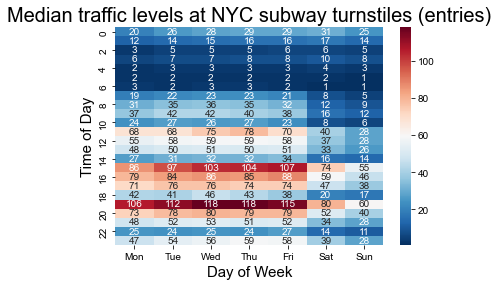

In [24]:
sns.heatmap(df4_pvt,cmap='RdBu_r',annot=True, fmt="g")

sns.set(rc = {'figure.figsize':(15,8)})
plt.title("Median traffic levels at NYC subway turnstiles (entries)", fontsize=20)
plt.xlabel("Day of Week", fontsize=15)
plt.ylabel("Time of Day", fontsize=15);

In [25]:
mask = ((df4_n["H"] == 9) | (df4_n["H"] == 10) | (df4_n["H"] == 11) |\
        (df4_n["H"] == 13) | (df4_n["H"] == 14) | (df4_n["H"] == 15) |\
        (df4_n["H"] == 16) | (df4_n["H"] == 17) | (df4_n["H"] == 17))
disp_H = df4_n[mask]
disp_HV = disp_H.groupby(["STATION","H"]).DAILY_ENTRIES.sum().reset_index()
disp_HV2 = disp_HV[["H","DAILY_ENTRIES"]]

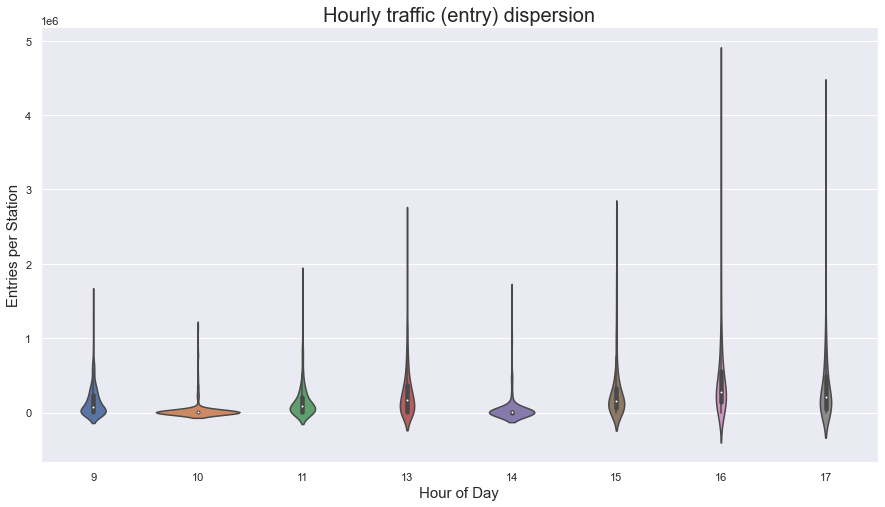

In [26]:
sns.violinplot(data=disp_HV2, x="H", y="DAILY_ENTRIES", fmt="g");
plt.title("Hourly traffic (entry) dispersion", fontsize=20)
plt.xlabel("Hour of Day", fontsize=15)
plt.ylabel("Entries per Station", fontsize=15);

In [27]:
dfpenn = df4_n[(df4_n["STATION"] == "34 ST-PENN STA") | (df4_n["STATION"] == "34 ST-HERALD SQ")]
dfpenn.CA.unique()

array(['R138', 'R142', 'A022', 'A025', 'N067', 'N068', 'N069', 'N070',
       'N071', 'N072', 'N073', 'N505', 'N506', 'N507', 'R135', 'R137',
       'R139', 'R141'], dtype=object)

In [28]:
dfpennm = dfpenn.groupby("CA").sum().reset_index().sort_values("DAILY_ENTRIES", ascending=False)

In [29]:
dfpennstation = dfpenn.groupby(["STATION","CA"]).size().reset_index().rename(columns={0:"count"})
dfpennstation.drop("count", axis=1)
dfpennm = pd.merge(dfpennm, dfpennstation, how="left", on=["CA"])

In [30]:
dfpennm.head()

,CA,ENTRIES,DAILY_ENTRIES,DoW,H,STATION,count
0,R138,6541490899107,9488469.0,196837,757618,34 ST-PENN STA,64863
1,N506,6977517664874,8081071.0,167844,593217,34 ST-HERALD SQ,55648
2,A025,3345269442049,7487086.0,110855,386478,34 ST-HERALD SQ,36507
3,N067,145390566907,5504148.0,156673,564707,34 ST-PENN STA,51721
4,N072,4714019919478,4514510.0,122274,438124,34 ST-PENN STA,40203


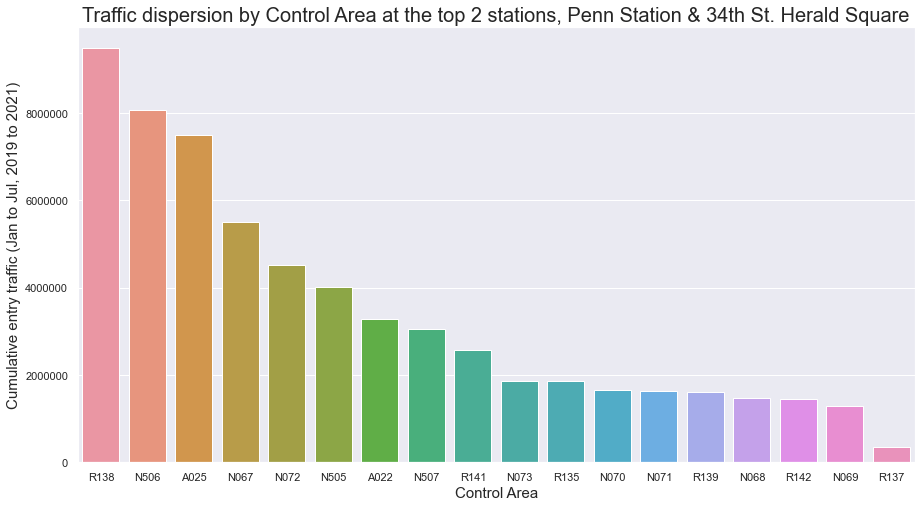

In [31]:
sns.barplot(data=dfpennm, x="CA", y="DAILY_ENTRIES")
plt.title("Traffic dispersion by Control Area at the top 2 stations, Penn Station & 34th St. Herald Square", fontsize=20)
plt.xlabel("Control Area", fontsize=15)
plt.ylabel("Cumulative entry traffic (Jan to Jul, 2019 to 2021)", fontsize=15)
plt.ticklabel_format(style='plain', axis='y')

In [32]:
mask = (((df4_n["DoW_n"] != "Sat") | (df4_n["DoW_n"] != "Sun")) & ((df4_n["H"] >= 10) & (df4_n["H"] <= 16)))
dfts = df4_n[mask].copy()

In [33]:
dfts["std"] = (dfts.groupby(["STATION","CA","DoW_n","H"]).DAILY_ENTRIES.transform(lambda x: (x.std())))

In [34]:
dfts["range"] = (dfts.groupby(["STATION","CA","DoW_n","H"]).DAILY_ENTRIES.transform(lambda x: (x.max() - x.min())))

In [35]:
dfts_m = dfts.groupby(["STATION","CA","DoW_n","H"])[["DAILY_ENTRIES"]].median().reset_index()
dfts_m.sort_values("DAILY_ENTRIES", ascending=False, inplace=True)

In [36]:
dfts_m_chart = dfts_m[0:50]
dfts_m_chart

,STATION,CA,DoW_n,H,DAILY_ENTRIES
13873,GRD CNTRL-42 ST,R238A,Mon,10,1406.0
13890,GRD CNTRL-42 ST,R238A,Tue,10,1336.0
13867,GRD CNTRL-42 ST,R238A,Fri,10,1262.0
5045,42 ST-PORT AUTH,N063A,Fri,10,1078.5
1358,145 ST,N019,Tue,10,1069.0
8243,ASTORIA DITMARS,R515,Tue,10,830.0
1288,14 ST-UNION SQ,A037,Fri,16,824.0
10366,CANAL ST,A066,Thu,16,772.5
10373,CANAL ST,A066,Wed,16,768.5
10353,CANAL ST,A066,Fri,16,768.0


In [37]:
dfts_m_chart = pd.merge(dfts_m_chart, dfts[["CA","DoW_n","H","range","std"]], how="left", on=["CA","DoW_n","H"])

dfts_m_chart.head(10)

,STATION,CA,DoW_n,H,DAILY_ENTRIES,range,std
0,GRD CNTRL-42 ST,R238A,Mon,10,1406.0,773.0,287.377394
1,GRD CNTRL-42 ST,R238A,Mon,10,1406.0,773.0,287.377394
2,GRD CNTRL-42 ST,R238A,Mon,10,1406.0,773.0,287.377394
3,GRD CNTRL-42 ST,R238A,Mon,10,1406.0,773.0,287.377394
4,GRD CNTRL-42 ST,R238A,Mon,10,1406.0,773.0,287.377394
5,GRD CNTRL-42 ST,R238A,Mon,10,1406.0,773.0,287.377394
6,GRD CNTRL-42 ST,R238A,Tue,10,1336.0,714.0,257.959207
7,GRD CNTRL-42 ST,R238A,Tue,10,1336.0,714.0,257.959207
8,GRD CNTRL-42 ST,R238A,Tue,10,1336.0,714.0,257.959207
9,GRD CNTRL-42 ST,R238A,Tue,10,1336.0,714.0,257.959207


In [38]:
dfts_m_chart.drop_duplicates(subset=["CA", "STATION", "DoW_n", "H"], inplace=True)

In [39]:
dfts_m_chart.head(20)

,STATION,CA,DoW_n,H,DAILY_ENTRIES,range,std
0,GRD CNTRL-42 ST,R238A,Mon,10,1406.0,773.0,287.377394
6,GRD CNTRL-42 ST,R238A,Tue,10,1336.0,714.0,257.959207
13,GRD CNTRL-42 ST,R238A,Fri,10,1262.0,850.0,313.402829
20,42 ST-PORT AUTH,N063A,Fri,10,1078.5,1269.0,537.218614
28,145 ST,N019,Tue,10,1069.0,0.0,NaN
29,ASTORIA DITMARS,R515,Tue,10,830.0,0.0,NaN
30,14 ST-UNION SQ,A037,Fri,16,824.0,1156.0,342.707280
151,CANAL ST,A066,Thu,16,772.5,940.0,305.827968
241,CANAL ST,A066,Wed,16,768.5,891.0,299.008353
331,CANAL ST,A066,Fri,16,768.0,1029.0,334.018989


In [40]:
dfts_m_chart.dropna(subset=["std"], axis=0, inplace=True)
dfts_m_chart.reset_index()
dfts_m_chart["std"] = dfts_m_chart["std"].round(1)

In [41]:
dfts_m_chart.sort_values(["STATION","DAILY_ENTRIES","std"], ascending=[True,False,True])
dfts_m_chart.rename(columns={"DAILY_ENTRIES":"Median", "std":"Standard Deviation", "range":"Range", "DoW_n":"Day of Week", "H":"Hour of Day"}, inplace=True)

In [42]:
dfts_m_chart["Rank, by Median"] = range(1,len(dfts_m_chart["Median"])+1)

In [43]:
dfts_m_chart.sort_values(["STATION","Median","Standard Deviation"], ascending=[True,False,True])

,STATION,CA,Day of Week,Hour of Day,Median,Range,Standard Deviation,"Rank, by Median"
30,14 ST-UNION SQ,A037,Fri,16,824.0,1156.0,342.7,5
419,14 ST-UNION SQ,A037,Thu,16,764.5,1098.0,307.0,9
799,14 ST-UNION SQ,A037,Wed,16,741.0,932.0,300.8,13
919,14 ST-UNION SQ,A037,Tue,16,739.5,1116.0,298.5,14
1310,14 ST-UNION SQ,A037,Mon,16,672.0,1048.0,280.9,19
1891,14 ST-UNION SQ,A037,Sat,16,614.0,1131.0,251.0,28
2191,18 AV,E012,Tue,10,592.5,253.0,178.9,33
1695,21 ST-QNSBRIDGE,N603,Mon,10,633.0,858.0,350.9,24
1126,23 ST,R131,Fri,16,706.0,977.0,300.3,17
1421,23 ST,R131,Thu,16,666.0,903.0,267.0,20


In [44]:
dftsmchart = dfts_m_chart[(dfts_m_chart["Rank, by Median"]<=30)].head(30)

DoW1 = {"Mon":0, "Tue":1, "Wed":2, "Thu":3, "Fri":4, "Sat":5, 'Sun':6}
dftsmchart["DOW"] = dftsmchart["Day of Week"].map(DoW1)
dftsmchart.sort_values(["DOW", "Hour of Day", "Rank, by Median"], ascending=True, inplace=True)
dftsmchart.drop("DOW", axis=1, inplace=True)
dftsmchart.head(30)

,STATION,CA,Day of Week,Hour of Day,Median,Range,Standard Deviation,"Rank, by Median"
0,GRD CNTRL-42 ST,R238A,Mon,10,1406.0,773.0,287.4,1
1695,21 ST-QNSBRIDGE,N603,Mon,10,633.0,858.0,350.9,24
1787,JKSN HT-ROOSVLT,N324,Mon,10,623.0,921.0,279.2,26
539,CANAL ST,A066,Mon,16,761.0,1139.0,320.7,10
1310,14 ST-UNION SQ,A037,Mon,16,672.0,1048.0,280.9,19
2025,YORK ST,N530,Mon,16,606.5,971.0,285.2,30
6,GRD CNTRL-42 ST,R238A,Tue,10,1336.0,714.0,258.0,2
1689,QUEENSBORO PLZ,R509,Tue,10,633.5,835.0,297.2,23
715,CANAL ST,A066,Tue,16,742.0,1138.0,317.2,12
919,14 ST-UNION SQ,A037,Tue,16,739.5,1116.0,298.5,14


In [45]:
dftoi["Year"] = dftoi.DATE_TIME.dt.year

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_55524/3679958591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftoi["Year"] = dftoi.DATE_TIME.dt.year


In [46]:
dftoiy = dftoi.drop(["DIVISION","TIME","DESC","ENTRIES","PREV_DATETIME","T"], axis=1)

In [47]:
dftoiy["daynum"] = dftoiy["DATE_TIME"].dt.dayofyear

In [48]:
dftoiy19 = dftoiy[dftoiy["Year"] == 2019]
dftoiy19s = dftoiy19.sort_values("daynum",ascending=True)
dftoiy19m = dftoiy19s.groupby("daynum").DAILY_ENTRIES.median().reset_index()
dftoiy20 = dftoiy[dftoiy["Year"] == 2020]
dftoiy20s = dftoiy20.sort_values("daynum",ascending=True)
dftoiy20m = dftoiy20s.groupby("daynum").DAILY_ENTRIES.median().reset_index()
dftoiy21 = dftoiy[dftoiy["Year"] == 2021]
dftoiy21s = dftoiy21.sort_values("daynum",ascending=True)
dftoiy21m = dftoiy21s.groupby("daynum").DAILY_ENTRIES.median().reset_index()

In [49]:
from functools import reduce
dftoiy_all = [dftoiy19m, dftoiy20m, dftoiy21m]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['daynum'], how='inner'), dftoiy_all)

In [50]:
df_merged.rename(columns={"DAILY_ENTRIES_x":"Median Traffic 2019", "DAILY_ENTRIES_y": "Median Traffic 2020", "DAILY_ENTRIES": "Median Traffic 2021"})

,daynum,Median Traffic 2019,Median Traffic 2020,Median Traffic 2021
0,1,65.0,67.0,18.0
1,2,161.0,158.0,28.0
2,3,162.0,159.0,18.0
3,4,144.0,94.0,48.0
4,5,87.0,75.0,48.0
...,...,...,...,...
207,208,100.0,16.0,68.0
208,209,84.0,36.0,68.0
209,210,160.0,37.0,66.0
210,211,171.0,39.0,69.0


Text(0, 0.5, 'Median entry traffic at each turnstile')

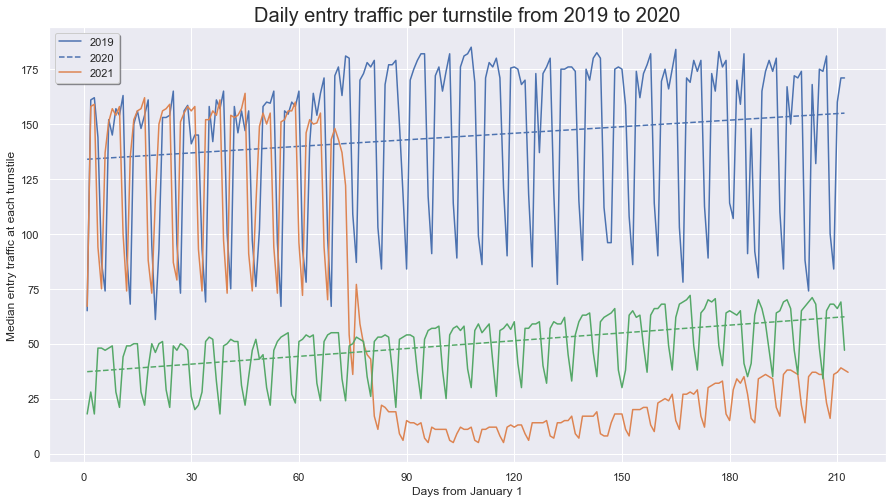

In [51]:
from matplotlib import pylab

#sns.lineplot(data=df_merged, x="daynum")
sns.lineplot(data=dftoiy19m, x="daynum", y="DAILY_ENTRIES")

z19 = np.polyfit(dftoiy19m.daynum, dftoiy19m.DAILY_ENTRIES, 1)
p19 = np.poly1d(z19)
pylab.plot(dftoiy19m.daynum,p19(dftoiy19m.daynum),"b--")

sns.lineplot(data=dftoiy20m, x="daynum", y="DAILY_ENTRIES")

#z20 = np.polyfit(dftoiy20m.daynum, dftoiy20m.DAILY_ENTRIES, 1)
#p20 = np.poly1d(z20)
#pylab.plot(dftoiy20m.daynum,p20(dftoiy20m.daynum))

sns.lineplot(data=dftoiy21m, x="daynum", y="DAILY_ENTRIES")

z21 = np.polyfit(dftoiy21m.daynum, dftoiy21m.DAILY_ENTRIES, 1)
p21 = np.poly1d(z21)
pylab.plot(dftoiy21m.daynum,p21(dftoiy21m.daynum),"g--")

plt.legend(['2019','2020', '2021'], shadow = True);
plt.xticks(ticks=list(range(0,212,30)));
plt.title("Daily entry traffic per turnstile from 2019 to 2020", fontsize=20)
plt.xlabel("Days from January 1", fontsize=12)
plt.ylabel("Median entry traffic at each turnstile", fontsize=12)

In [ ]:
'''SQL Codes 

ALTER TABLE mta_data RENAME COLUMN "C/A" TO "CA"; --change column name

CREATE TABLE mta_data_H1_19to21 AS
SELECT *
FROM mta_data
WHERE (DATE LIKE '%2021' OR DATE LIKE '%2020' OR DATE LIKE '%2019') AND (DATE LIKE '07%' OR DATE LIKE '06%' OR DATE LIKE '05%' OR DATE LIKE '04%' OR DATE LIKE '03%' OR DATE LIKE '02%' OR DATE LIKE '01%');

--filter for H1 2021 data

DROP TABLE IF EXISTS [the name of the table] --in case I need to regenerate a table

CREATE TABLE mta_H1_19to21_ranked AS
SELECT *, RANK() OVER(PARTITION BY CA, UNIT, SCP, STATION, DATE ORDER BY TIME DESC) AS daily_rank_turns
FROM mta_data_H1_19to21;
'''